# ID5030 Assignment 6
### Convolutional Neural Networks in Semantic Segmentation
### By: P Akhil Reddy
### Roll No. CH20B076

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
from PIL import Image

import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
dir = '/content/gdrive/MyDrive/ID_A6'

In [4]:
train_df = pd.read_csv(dir+'/Dataset/training_set_pixel_size_and_HC.csv')

In [5]:
train_df.head()

,filename,pixel size,head circumference (mm)
0,1_HC.png,0.069136,44.30
1,2_HC.png,0.089659,56.81
2,3_HC.png,0.062033,68.75
3,4_HC.png,0.091291,69.00
4,5_HC.png,0.061240,59.81


In [6]:
train_df.shape

(999, 3)

In [7]:
train_img_names = train_df['filename'].values

val_img_names = train_img_names[799:]
train_img_names = train_img_names[:799]

### Creating masks for segmentation and saving them in folders.

In [50]:
# Creating masks for train dataset

for file_name in train_img_names:
    name = file_name[0:len(file_name)-4]

    image = cv2.imread(dir + "/Dataset/training_set/" + name + "_Annotation.png", 0)

    im = image.copy()
    im = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)

    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for c in contours:
        ellipse = cv2.fitEllipse(c)
        cv2.ellipse(im, ellipse, (255,255,255), -1)

    cv2.imwrite(dir + "/Dataset/train_masks/" + name + "_Annotation.png", im)

# Creating masks for test dataset

for file_name in val_img_names:
    name = file_name[0:len(file_name)-4]

    image = cv2.imread(dir + "/Dataset/val_set/" + name + "_Annotation.png", 0)

    im = image.copy()
    im = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)

    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for c in contours:
        ellipse = cv2.fitEllipse(c)
        cv2.ellipse(im, ellipse, (255,255,255), -1)

    cv2.imwrite(dir + "/Dataset/val_masks/"+name+"_Annotation.png", im)

### Defining the dataset

In [9]:
# Checking for the availability of the GPUs, and if available will be used in the code
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, data, transform=None):

        self.x_train = sorted(glob.glob(dir + '/Dataset/training_set/*HC.png'))
        self.y_train = sorted(glob.glob(dir + '/Dataset/train_masks/*_Annotation.png'))
        self.x_val = sorted(glob.glob(dir + '/Dataset/val_set/*HC.png'))
        self.y_val = sorted(glob.glob(dir + '/Dataset/val_masks/*_Annotation.png'))
        self.x_test = sorted(glob.glob(dir + '/Dataset/test_set/*HC.png'))

        self.data = data

    def __len__(self):

        if(self.data == 'train'):
            return len(self.x_train)

        elif(self.data == 'validate'):
            return len(self.x_val)

        elif(self.data == 'test'):
            return len(self.x_test)

        else:
            return ValueError("No data")


    def __getitem__(self, idx):

        if(self.data == 'train'):

            x_arr = self.x_train
            y_arr = self.y_train

        elif(self.data == 'validate'):

            x_arr = self.x_val
            y_arr = self.y_val            

        elif(self.data == 'test'):

            x_arr = self.x_test

            x_image = Image.open(x_arr[idx])
            x_image = x_image.convert('L').resize((572, 572))
            x = np.array(x_image).reshape(1, 572, 572)

            return torch.from_numpy(x).float().to(device)

        else:
            return ValueError("No data")

        x_image = Image.open(x_arr[idx])
        x_image = x_image.convert('L').resize((572, 572))
        x = np.array(x_image).reshape(1, 572, 572)

        y_image = Image.open(y_arr[idx])
        y_image = y_image.convert('L').resize((572, 572))
        y = np.array(y_image).reshape(1, 572, 572)

        return torch.from_numpy(x).float().to(device), torch.from_numpy(y).float().to(device)


## Custom Model

### Defining the Custom Model

In [11]:
class double_conv(nn.Module):

    def __init__(self, input_channels, output_channels, down=True):
        super(double_conv, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(output_channels),
                                   nn.ReLU(inplace = True),
                                   nn.Dropout(0.5),
                                 )
        self.conv2 = nn.Sequential(nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(output_channels),
                                   nn.ReLU(inplace = True),
                                   nn.Dropout(0.5),
                                  )

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)+x1
        return x2

class pool(nn.Module):
    def __init__(self):
        super(pool, self).__init__()
        self.max_pool = nn.Sequential(nn.MaxPool2d(2),)

    def forward(self,x):
        x = self.max_pool(x)
        return x
    
class out_conv(nn.Module):

    def __init__(self, input_channels, output_channels):
        super(out_conv, self).__init__()
        self.conv = nn.Sequential(
                                 nn.Conv2d(input_channels, output_channels, kernel_size=1),
                                 nn.Sigmoid())


    def forward(self, x):
        x = self.conv(x)
        return x
    
class up_conv(nn.Module):

    def __init__(self, input_channels, output_channels):
        super(up_conv, self).__init__()
        self.conv_t = nn.ConvTranspose2d(input_channels, input_channels, kernel_size=2, stride=2)
        self.conv = double_conv(input_channels, output_channels)

    def forward(self, x):
        x1 = self.conv_t(x)
        x2 = self.conv(x1)
        return x2
    

class SomeNet(nn.Module):
    def __init__(self):
        super(SomeNet, self).__init__()

        self.pool = pool()
        self.inc_conv = double_conv(1, 64)
        self.down_conv1 = double_conv(64, 128)
        self.down_conv2 = double_conv(128, 256)
        self.up_conv1 = up_conv(256, 128)
        self.up_conv2 = up_conv(128, 64)
        self.out_conv = out_conv(64, 1)

    def forward(self, x):
        xin = self.inc_conv(x)
        xin_pool = self.pool(xin)
        xd1 = self.down_conv1(xin_pool)
        xd1_pool = self.pool(xd1)
        xd2 = self.down_conv2(xd1_pool)

        xu1 = self.up_conv1(xd2)
        xu2 = self.up_conv2(xu1)
        xout = self.out_conv(xu2)
        return xout

In [12]:
num_epochs = 20
batch_size = 2

In [27]:
train_dataset = Dataset('train', None)
val_dataset = Dataset('validate', None)
test_dataset = Dataset('test', None)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [71]:
# Defining the model, loss functions, optimizer, and scheduler

some_model = SomeNet().to(device)

loss_function = nn.BCELoss(reduction='mean')

optimizer = optim.Adam(some_model.parameters(), lr=1e-4)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, min_lr=1e-9)

In [15]:
# Defining the loss as the dice coefficient

def dice_sim(pred, truth):
# Returns dice coefficient which is used to evaluate semantic segmentation models

    # Epsilon is used to prevent division by zero
    epsilon = 1e-6

    m1 = pred.view(pred.size(0), -1).bool()
    m2 = truth.view(pred.size(0), -1).bool()
    
    return (((2*(torch.logical_and(m1, m2).sum(dim=1)) + epsilon) / (m1.sum(dim=1) + m2.sum(dim=1) + epsilon)).sum(dim=0))/2

In [72]:
train_losses = []
val_losses = []
val_dice_losses = []

In [ ]:
for epoch in range(num_epochs):

    running_loss = 0
    val_loss = 0
    val_dice_score = 0

    # Training
    for i, data in enumerate(train_loader):
        x_train, y_train = data
        y_train = y_train/255
        optimizer.zero_grad()

        # Forward propagation
        pred = some_model(x_train)

        # Calculation of loss
        loss = loss_function(pred, y_train)

        # Back propagation
        loss.backward()

        # Updating the weights
        optimizer.step()

        # Adding the loss
        running_loss += loss.item()

    # Validation set
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            x_val, y_val = data
            y_val = y_val/255

            # Forward Propagation
            pred = some_model(x_val)

            # Rounding off the predictions
            pred = torch.round(pred)

            # Calculating the losses and the dice score
            loss = loss_function(pred, y_val)
            val_loss += loss.item()
            val_dice_score += dice_sim(pred, y_val)

    epoch_train_loss = running_loss / (len(train_dataset)//batch_size+1)
    epoch_val_loss = val_loss / (len(val_dataset)//batch_size+1)
    epoch_val_dice_score = val_dice_score / (len(val_dataset)//batch_size+1)
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    val_dice_losses.append(epoch_val_dice_score)
    scheduler.step(epoch_val_loss)

    print(f"For epoch {epoch + 1}: train_loss = {epoch_train_loss}, val_loss = {epoch_val_loss}, val_dice_score = {epoch_val_dice_score}")

For epoch 1: train_loss = 0.5140031494945287, val_loss = 24.877951385951278, val_dice_score = 0.5527838468551636
For epoch 2: train_loss = 0.44799351170659063, val_loss = 23.160584657499104, val_dice_score = 0.5611957907676697
For epoch 3: train_loss = 0.42759577207267285, val_loss = 21.78961471519848, val_dice_score = 0.5793955326080322
For epoch 4: train_loss = 0.41535112373530864, val_loss = 22.096805166490007, val_dice_score = 0.5440237522125244
For epoch 5: train_loss = 0.40156886745244263, val_loss = 20.276078309163008, val_dice_score = 0.6121934652328491
For epoch 6: train_loss = 0.3865106401592493, val_loss = 18.327409678166454, val_dice_score = 0.6596111059188843
For epoch 7: train_loss = 0.3715897577628493, val_loss = 17.81163774622549, val_dice_score = 0.659950852394104
For epoch 8: train_loss = 0.35977662753313777, val_loss = 16.78187370300293, val_dice_score = 0.6851846575737


In [ ]:
print(f"The dice score obtained for the validation dataset after training = {val_dice_losses[-1]}")

### Plotting the training and validation losses vs epochs for the custom model.

In [ ]:
plt.plot(list(range(1, num_epochs)), train_losses)
plt.plot(list(range(1, num_epochs)), val_losses)
plt.title('Train and validation losses vs epochs for custom model')
plt.legend('Train losses', 'Validation losses')

### Testing the custom model on an image from test dataset.

torch.Size([572, 572])


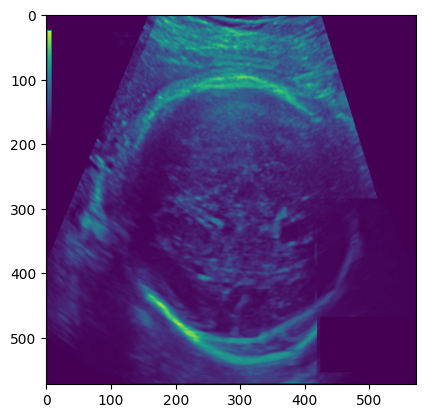

In [48]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        x_test = data

        # Forward Propagation
        pred = some_model(x_test)

        # Rounding off the predictions
        pred = torch.round(pred)
        break

image = pred.cpu().sum(axis=0).reshape(572, 572)
x_test = x_test.cpu().sum(axis=0).reshape(572, 572)
print(image.shape)

plt.imshow(x_test.cpu())

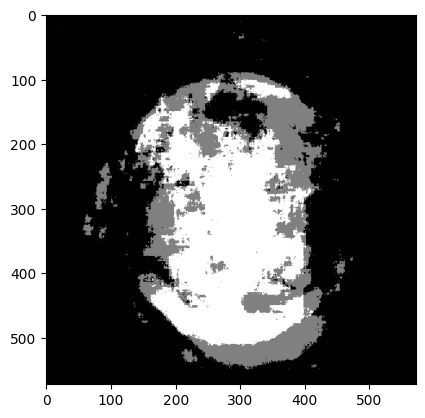

In [49]:
plt.imshow(image, cmap='gray')

## UNet Model

### Defining the UNet model

In [52]:
class up_conv2(nn.Module):

    def __init__(self, input_channels, output_channels):
        super(up_conv2, self).__init__()
        self.conv_t = nn.ConvTranspose2d(input_channels//2, input_channels//2, kernel_size=2, stride=2)
        self.conv = double_conv(input_channels, output_channels)

    def forward(self, x1, x2):
        x1 = self.conv_t(x1)
        diff1 = x2.shape[2]-x1.shape[2]
        diff2 = x2.shape[3]-x1.shape[3]
        x1 = F.pad(x1, pad=(diff1//2, diff1 - diff1//2, diff2//2, diff2 - diff2//2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.pool = pool()
        self.inc_conv = double_conv(1, 64)
        self.down_conv1 = double_conv(64, 128)
        self.down_conv2 = double_conv(128, 256)
        self.down_conv3 = double_conv(256, 512)
        self.down_conv4 = double_conv(512, 512)
        self.up_conv1 = up_conv2(1024, 256)
        self.up_conv2 = up_conv2(512, 128)
        self.up_conv3 = up_conv2(256, 64)
        self.up_conv4 = up_conv2(128, 64)
        self.out_conv1 = out_conv(64, 1)

    def forward(self, x):

        xin = self.inc_conv(x)
        xin_pool = self.pool(xin)
        xd1 = self.down_conv1(xin_pool)
        xd1_pool = self.pool(xd1)
        xd2 = self.down_conv2(xd1_pool)
        xd2_pool = self.pool(xd2)
        xd3 = self.down_conv3(xd2_pool)
        xd3_pool = self.pool(xd3)
        xd4 = self.down_conv4(xd3_pool)


        xu1 = self.up_conv1(xd4, xd3)
        xu2 = self.up_conv2(xu1, xd2)
        xu3 = self.up_conv3(xu2, xd1)
        xu4 = self.up_conv4(xu3, xin)
        xout = self.out_conv1(xu4)
        return xout


In [53]:
num_epochs = 10
batch_size = 2

In [54]:
# Defining the model, loss functions, optimizer, and scheduler

model = UNet().to(device)

loss_function = nn.BCELoss(reduction='mean')

optimizer = optim.Adam(model.parameters(), lr=1e-4)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, min_lr=1e-9)

### Training the UNet model

In [55]:
train_losses = []
val_losses = []

In [57]:
for epoch in range(num_epochs):

    running_loss = 0
    val_loss = 0
    val_dice_score = 0

    # Training set
    for i, data in enumerate(train_loader):
        x_train, y_train = data
        y_train = y_train/255
        optimizer.zero_grad()

        # Forward propagation
        pred = model(x_train)

        # Calculation of loss
        loss = loss_function(pred, y_train)

        # Back propagation
        loss.backward()

        # Updating the weights
        optimizer.step()

        # Adding the loss
        running_loss += loss.item()

    # Validation set
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            x_val, y_val = data
            y_val = y_val/255

            # Forward Propagation
            pred = model(x_val)

            # Rounding off the predictions
            pred = torch.round(pred)

            # Calculating the losses and the dice score
            loss = loss_function(pred, y_val)
            val_loss += loss.item()
            val_dice_score += dice_sim(pred, y_val)

    epoch_train_loss = running_loss / (len(train_dataset)//batch_size+1)
    epoch_val_loss = val_loss / (len(val_dataset)//batch_size+1)
    epoch_val_dice_score = val_dice_score / (len(val_dataset)//batch_size+1)
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    val_dice_losses.append(epoch_val_dice_score)
    scheduler.step(epoch_val_loss)

    print(f"For epoch {epoch + 1}: train_loss = {epoch_train_loss}, val_loss = {epoch_val_loss}, val_dice_score = {epoch_val_dice_score}")

For epoch 1: train_loss = 0.30190103270113466, val_loss = 9.4215618430978, val_dice_score = 0.8200807571411133
For epoch 2: train_loss = 0.17553266558796168, val_loss = 9.76183305400433, val_dice_score = 0.8156597018241882
For epoch 3: train_loss = 0.14186481738463044, val_loss = 7.420933985474086, val_dice_score = 0.8540111184120178
For epoch 4: train_loss = 0.11769008948467671, val_loss = 6.231781765966132, val_dice_score = 0.8757849931716919
For epoch 5: train_loss = 0.10300317848101258, val_loss = 4.7346290267340025, val_dice_score = 0.9075073003768921
For epoch 6: train_loss = 0.09822210136801005, val_loss = 5.848664178706632, val_dice_score = 0.887610137462616
For epoch 7: train_loss = 0.08956122583709657, val_loss = 4.61570423192317, val_dice_score = 0.9076906442642212
For epoch 8: train_loss = 0.08086337743792683, val_loss = 4.682698351321834, val_dice_score = 0.9063857197761536
For epoch 9: train_loss = 0.07868079523090273, val_loss = 5.046609697955669, val_dice_score = 0.8995

In [58]:
print(f"The dice score obtained for the validation dataset after training = {val_dice_losses[-1]}")

The dice score obtained for the validation dataset after training = 0.9046175479888916


### Plotting the training and validation losses vs epochs for the custom model.

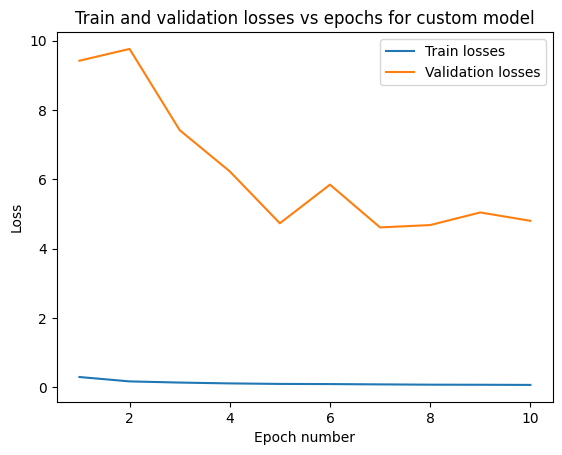

In [66]:
plt.plot(list(range(1, num_epochs+1)), train_losses)
plt.plot(list(range(1, num_epochs+1)), val_losses)
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.title('Train and validation losses vs epochs for custom model')
plt.legend(['Train losses', 'Validation losses']);

### We observe that the dice score obtained for the UNet model is higher than that obtained by the custom model.
### So we can conclude that UNet performs better.

### Testing the UNet model on an image from the test dataset.

torch.Size([572, 572])


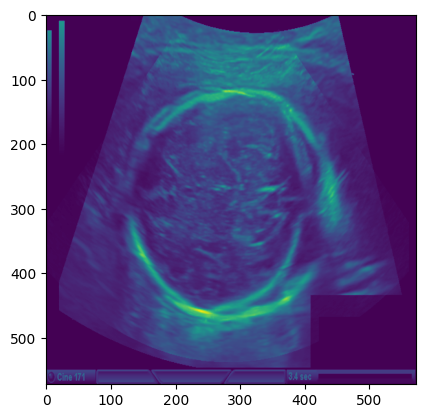

In [67]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        x_test = data

        # Forward Propagation
        pred = model(x_test)

        # Rounding off the predictions
        pred = torch.round(pred)
        break

image = pred.cpu().sum(axis=0).reshape(572, 572)
x_test = x_test.cpu().sum(axis=0).reshape(572, 572)
print(image.shape)

plt.imshow(x_test.cpu())

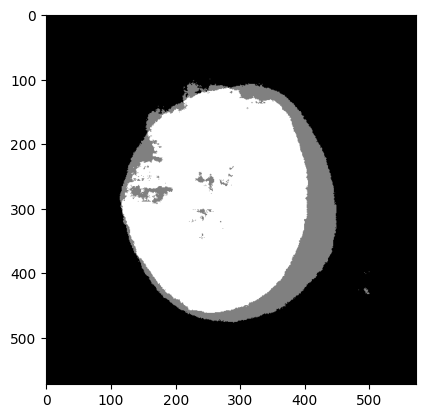

In [68]:
plt.imshow(image, cmap='gray')